# Dependency

In [1]:
### Preparation

# Data processing
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
import missingno as miss
from pandas.api.types import CategoricalDtype # Ordering categories
import re
# Connection to sql
import sqlite3

# Data Viz Libraries
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import wordcloud # Wordcloud
from PIL import Image # For mask
import plotly.figure_factory as ff # For export table

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Web-scraping libraries
import requests # For downloading the website
from bs4 import BeautifulSoup # For parsing the website
import time # To put the system to sleep
import random # for random numbers

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import LinearSVC as SVC
from sklearn import tree # For plotting the decision tree rules


# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For permutation,pdp,ice
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from pdpbox import pdp

# Misc
import warnings
warnings.filterwarnings("ignore")

# Part 1 Top 50 Cities with Accumulated Most H1B Filings (YR 2018 Data)

## Data Collection

In [2]:
### Create a list of urls to scrape

# Parse the main page
url_main = 'https://h1bdata.info/topcities.php'
soup_1 = BeautifulSoup(requests.get(url_main).content, 'html.parser')
    
# Extract relevant links
links = []
for tag in soup_1.find_all("a"):
    href = tag.attrs.get("href")
    if "city=" in href and "https:" not in href:
        links.append("https://h1bdata.info/" + href.replace("2020","2018"))
        
target = links[0:50]

In [3]:
### Building a scraper for a single page

def h1b_scraper(url=None):
    """Scrape a single BIT URL (link when clicking a country).

    Args:
        url: A h1b url to scrape.

    Returns:
        DataFrame: frame containing the first table following a given BIT url
    """

    # Download the webpage
    page = requests.get(url)

    # If a connection was reached
    if page.status_code == 200:

        # Parse
        soup = BeautifulSoup(page.content, 'html.parser')
        
        #Read table
        dat = pd.read_html(page.text)[0]
        
        #grab the city
        city = url.split("=")[-1].replace("+"," ")
        dat["city"] = city

    #Return the data frame
    return dat

In [4]:
### Using the scraper build above to scrape relevant links, and a concat the data to a large data frame

def link_scrape(urls=None,sleep=2):
    """Scrape multiple BIT URLS.

    Args:
        urls (list): list of valid BIT urls.
        sleep (int): Integer value specifying how long the machine should be
                    put to sleep (random uniform). Defaults to 2.

    Returns:
        DataFrame: frame containing tables following each BIT url
    """
    scraped_data = []
    for url in urls:
        
        # Keep track of where we are at
        print(url)

        # Scrape the content, append the data frame to the empty list
        scraped_data.append(h1b_scraper(url))

        # Put the system to sleep for a random draw of time (be kind)
        time.sleep(random.uniform(0,sleep))
        
        # Create a large data frame
        dat = pd.concat(scraped_data)
        
    return dat

In [5]:
# Make a copy of target in case some cities don't have data
target2 = target.copy()

In [6]:
# Scrape for raw data frame
raw = link_scrape(urls=target2)

https://h1bdata.info/index.php?year=2018&city=NEW+YORK
https://h1bdata.info/index.php?year=2018&city=SAN+FRANCISCO
https://h1bdata.info/index.php?year=2018&city=HOUSTON
https://h1bdata.info/index.php?year=2018&city=CHICAGO
https://h1bdata.info/index.php?year=2018&city=ATLANTA
https://h1bdata.info/index.php?year=2018&city=SAN+JOSE
https://h1bdata.info/index.php?year=2018&city=SUNNYVALE
https://h1bdata.info/index.php?year=2018&city=SEATTLE
https://h1bdata.info/index.php?year=2018&city=MOUNTAIN+VIEW
https://h1bdata.info/index.php?year=2018&city=AUSTIN
https://h1bdata.info/index.php?year=2018&city=IRVING
https://h1bdata.info/index.php?year=2018&city=DALLAS
https://h1bdata.info/index.php?year=2018&city=CHARLOTTE
https://h1bdata.info/index.php?year=2018&city=REDMOND
https://h1bdata.info/index.php?year=2018&city=BOSTON
https://h1bdata.info/index.php?year=2018&city=SANTA+CLARA
https://h1bdata.info/index.php?year=2018&city=PLANO
https://h1bdata.info/index.php?year=2018&city=PHILADELPHIA
https:/

In [7]:
# See result
raw

EMPLOYER                             JOB TITLE  \
0          BARCLAYS SERVICES CORP  .NET QLIK DEVELOPER SYSTEMS ENGINEER   
1                        VLINKINC                        .NET ARCHITECT   
2                        VLINKINC                        .NET ARCHITECT   
3             DIGITAL SCRIPTS INC                        .NET DEVELOPER   
4             DIGITAL SCRIPTS INC                        .NET DEVELOPER   
...                           ...                                   ...   
1693    ENTREGA SYSTEMS GROUP INC             WEB APPLICATION DEVELOPER   
1694                BROADGATE INC                         WEB DEVELOPER   
1695                     ELIX INC                         WEB DEVELOPER   
1696  PRECISION TECHNOLOGIES CORP                 WINDOWS ADMINISTRATOR   
1697     WEBASTO ROOF SYSTEMS INC                           WPS MANAGER   

      BASE SALARY      LOCATION SUBMIT DATE  START DATE CASE STATUS      city  
0          125000  NEW YORK, NY  06/13/2018  07/02/2018   CERTIFIED  NEW YORK  
1           85000  NEW YORK, NY  12/13/2018  12/26/2018   WITHDRAWN  NEW YORK  
2           85000  NEW YORK, NY  12/20/2018  01/03/2019   CERTIFIED  NEW YORK  
3           92700  NEW YORK, NY  11/12/2018  12/28/2018   CERTIFIED  NEW YORK  
4           92800  NEW YORK, NY  08/30/2018  12/28/2018   CERTIFIED  NEW YORK  
...           ...           ...         ...         ...         ...       ...  
1693        62000      TROY, MI  03/30/2018  09/08/2018   CERTIFIED      TROY  
1694        60000      TROY, MI  02/20/2018  03/01/2018   CERTIFIED      TROY  
1695        71635      TROY, MI  03/30/2018  09/28/2018   CERTIFIED      TROY  
1696        61420      TROY, NY  04/17/2018  04/17/2018   CERTIFIED      TROY  
1697       100693      TROY, MI  09/20/2018  10/01/2018   CERTIFIED      TROY  

[289871 rows x 8 columns]

In [8]:
# Make a copy of raw to conduct manipulations
dat_content = raw.copy()

## Initial Data Cleaning

**Column Name**

In [9]:
dat_content.columns = [c.lower().replace(" ","_") for c in dat_content.columns]

In [10]:
dat_content.columns

Index(['employer', 'job_title', 'base_salary', 'location', 'submit_date',
       'start_date', 'case_status', 'city'],
      dtype='object')

**Enough Samples?**

In [11]:
dat_content.case_status.value_counts()

CERTIFIED                277548
WITHDRAWN                  8384
DENIED                     3495
CERTIFIED - WITHDRAWN       444
Name: case_status, dtype: int64

**Data Types**

In [12]:
dat_content.dtypes

employer       object
job_title      object
base_salary     int64
location       object
submit_date    object
start_date     object
case_status    object
city           object
dtype: object

In [13]:
# String type
for col in ['employer', 'job_title', 'location', 'case_status']:
    dat_content[col] = dat_content[col].astype('string')

**Missingness**

Not a lot. We can drop them.

In [14]:
# Check NA
dat_content.isna().sum()

employer       0
job_title      4
base_salary    0
location       0
submit_date    0
start_date     0
case_status    0
city           0
dtype: int64

In [15]:
# Drop NA
dat_content = dat_content.dropna()

**Clean `job_title`**

In [16]:
# Keep alphabet only
job_title_clean =[]
whitelist = set('0123456789 ABCDEFGHIJKLMNOPQRSTUVWXYZ')
for row in dat_content.job_title:
    row = ''.join(filter(whitelist.__contains__, row))
    job_title_clean.append(row)

In [17]:
# Assign the list to a new column
dat_content['job_title_clean'] = job_title_clean

In [18]:
# Drop uncleaned job title
dat_content = dat_content.drop(columns = ['job_title'])

In [19]:
# See result
dat_content

employer  base_salary      location submit_date  \
0          BARCLAYS SERVICES CORP       125000  NEW YORK, NY  06/13/2018   
1                        VLINKINC        85000  NEW YORK, NY  12/13/2018   
2                        VLINKINC        85000  NEW YORK, NY  12/20/2018   
3             DIGITAL SCRIPTS INC        92700  NEW YORK, NY  11/12/2018   
4             DIGITAL SCRIPTS INC        92800  NEW YORK, NY  08/30/2018   
...                           ...          ...           ...         ...   
1693    ENTREGA SYSTEMS GROUP INC        62000      TROY, MI  03/30/2018   
1694                BROADGATE INC        60000      TROY, MI  02/20/2018   
1695                     ELIX INC        71635      TROY, MI  03/30/2018   
1696  PRECISION TECHNOLOGIES CORP        61420      TROY, NY  04/17/2018   
1697     WEBASTO ROOF SYSTEMS INC       100693      TROY, MI  09/20/2018   

      start_date case_status      city                      job_title_clean  
0     07/02/2018   CERTIFIED  NEW YORK  NET QLIK DEVELOPER SYSTEMS ENGINEER  
1     12/26/2018   WITHDRAWN  NEW YORK                        NET ARCHITECT  
2     01/03/2019   CERTIFIED  NEW YORK                        NET ARCHITECT  
3     12/28/2018   CERTIFIED  NEW YORK                        NET DEVELOPER  
4     12/28/2018   CERTIFIED  NEW YORK                        NET DEVELOPER  
...          ...         ...       ...                                  ...  
1693  09/08/2018   CERTIFIED      TROY            WEB APPLICATION DEVELOPER  
1694  03/01/2018   CERTIFIED      TROY                        WEB DEVELOPER  
1695  09/28/2018   CERTIFIED      TROY                        WEB DEVELOPER  
1696  04/17/2018   CERTIFIED      TROY                WINDOWS ADMINISTRATOR  
1697  10/01/2018   CERTIFIED      TROY                          WPS MANAGER  

[289867 rows x 8 columns]

In [20]:
# Fix google company name(because it restructured in 2017)
dat_content1 = dat_content.copy()
dat_content1.employer = [g.replace("GOOGLE INC", "GOOGLE LLC") for g in dat_content.employer]

## Questions

### 1.	Which companies have the highest number of H1B filings in 2018? What about grouping by cities? What are the most popular job titles?

#### Companies (Top 100)

In [21]:
# Top 100 companies(LCA applicants number)
company_summary = (dat_content1
 .groupby('employer')
 .size()
 .sort_values(ascending = False)
 .reset_index()
 .rename(columns = {0: 'count'})
 .head(100)                  
)
company_summary

employer  count
0                  DELOITTE CONSULTING LLP  10019
1        TATA CONSULTANCY SERVICES LIMITED   6354
2   COGNIZANT TECHNOLOGY SOLUTIONS US CORP   6009
3                          INFOSYS LIMITED   5707
4                    MICROSOFT CORPORATION   5621
..                                     ...    ...
95                     COLUMBIA UNIVERSITY    254
96                     SAPIENT CORPORATION    254
97                            SAP LABS LLC    253
98                   BARCLAYS SERVICES LLC    252
99                           PINTEREST INC    251

[100 rows x 2 columns]

In [22]:
# Check google company name
(company_summary[company_summary['employer']
                 .str.contains("GOOGLE")]
                 .groupby('employer').sum()
)

count
employer         
GOOGLE LLC   5326

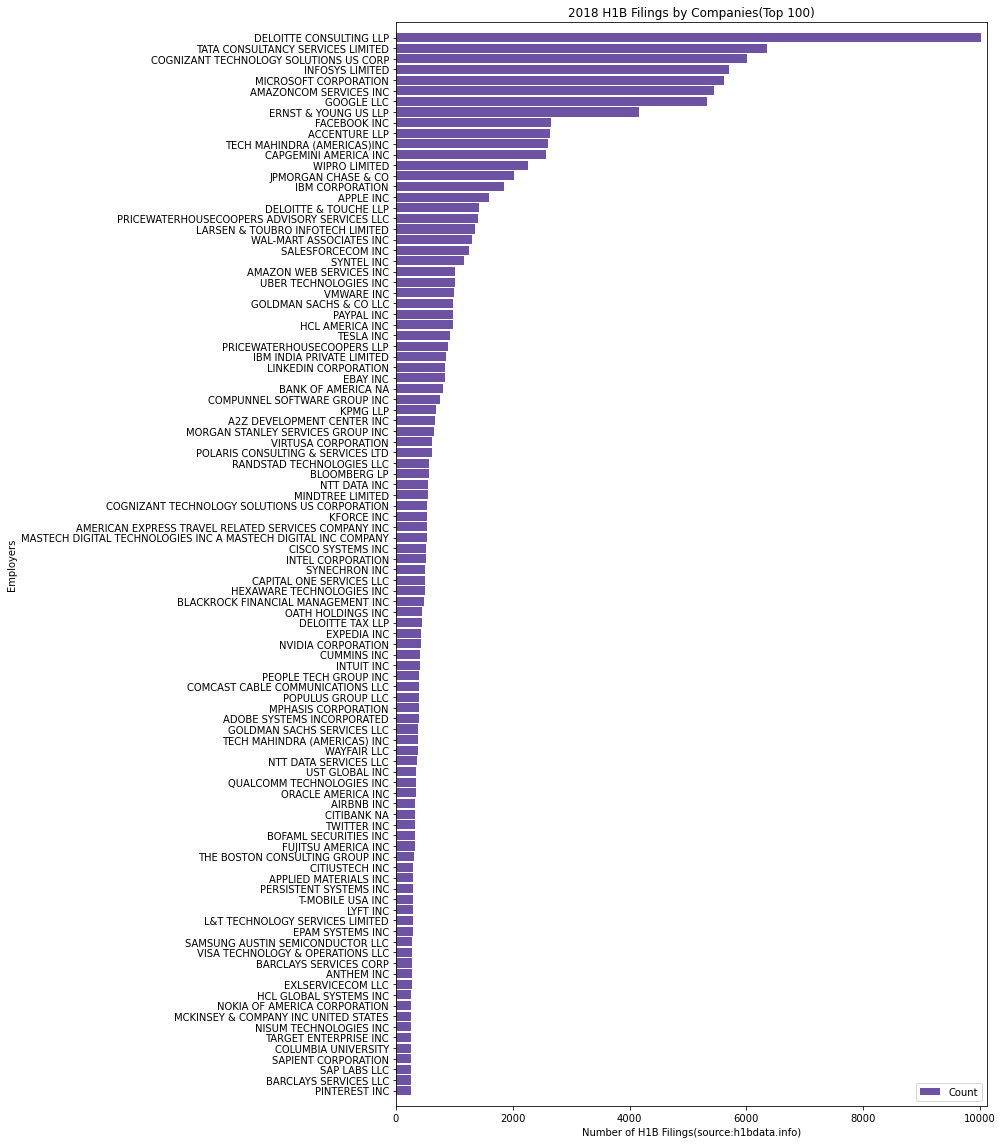

In [23]:
### Generate a bar plot, plot top 100
plt.figure(figsize = (14,16))
plt.barh(company_summary['employer'], company_summary['count'], color = '#6E53A4',height = 0.85, label ='Count')
plt.gca().invert_yaxis() # Invert axis
plt.margins(0.01) # Adjust margins
plt.xlabel('Number of H1B Filings(source:h1bdata.info)')
plt.ylabel('Employers')
plt.title('2018 H1B Filings by Companies(Top 100)')
plt.legend() # Show legend
plt.tight_layout()
plt.savefig('images/companies', dpi = 300)
plt.show()

In the original data set, there are Google INC and Google LLC.
After the reform, Google INC should be Google LLC.

#### Cities

In [24]:
# Top 50 cities in 2018(LCA applicants number)
city_summary = (dat_content1
 .groupby('city')
 .size()
 .sort_values(ascending = False)
 .reset_index()
 .rename(columns = {0: 'count'})                  
)
city_summary

city  count
0        NEW YORK  37323
1   SAN FRANCISCO  17194
2         CHICAGO  12076
3         HOUSTON  11525
4        SAN JOSE  11409
5         ATLANTA  10894
6         SEATTLE  10273
7       SUNNYVALE   9738
8          AUSTIN   7639
9          DALLAS   7484
10   PHILADELPHIA   7200
11         IRVING   7196
12        REDMOND   7158
13         BOSTON   7139
14      CHARLOTTE   7131
15  MOUNTAIN VIEW   7049
16          PLANO   6422
17    SANTA CLARA   5884
18       COLUMBUS   5057
19        PHOENIX   5040
20    LOS ANGELES   4982
21       BELLEVUE   4950
22    JERSEY CITY   4769
23     ALPHARETTA   4664
24      PALO ALTO   4269
25      SAN DIEGO   4142
26          TAMPA   3931
27     PITTSBURGH   3900
28     WASHINGTON   3459
29         IRVINE   3151
30        FREMONT   2890
31     RICHARDSON   2844
32     MENLO PARK   2755
33       RICHMOND   2745
34    MINNEAPOLIS   2734
35         MCLEAN   2664
36      CAMBRIDGE   2615
37     WILMINGTON   2545
38         DURHAM   2446
39      PRINCETON   2435
40          MIAMI   2376
41   INDIANAPOLIS   2370
42     PLEASANTON   2265
43    SAN ANTONIO   2071
44   JACKSONVILLE   2063
45    BENTONVILLE   2062
46         EDISON   1871
47      CUPERTINO   1849
48           TROY   1698
49     PISCATAWAY   1521

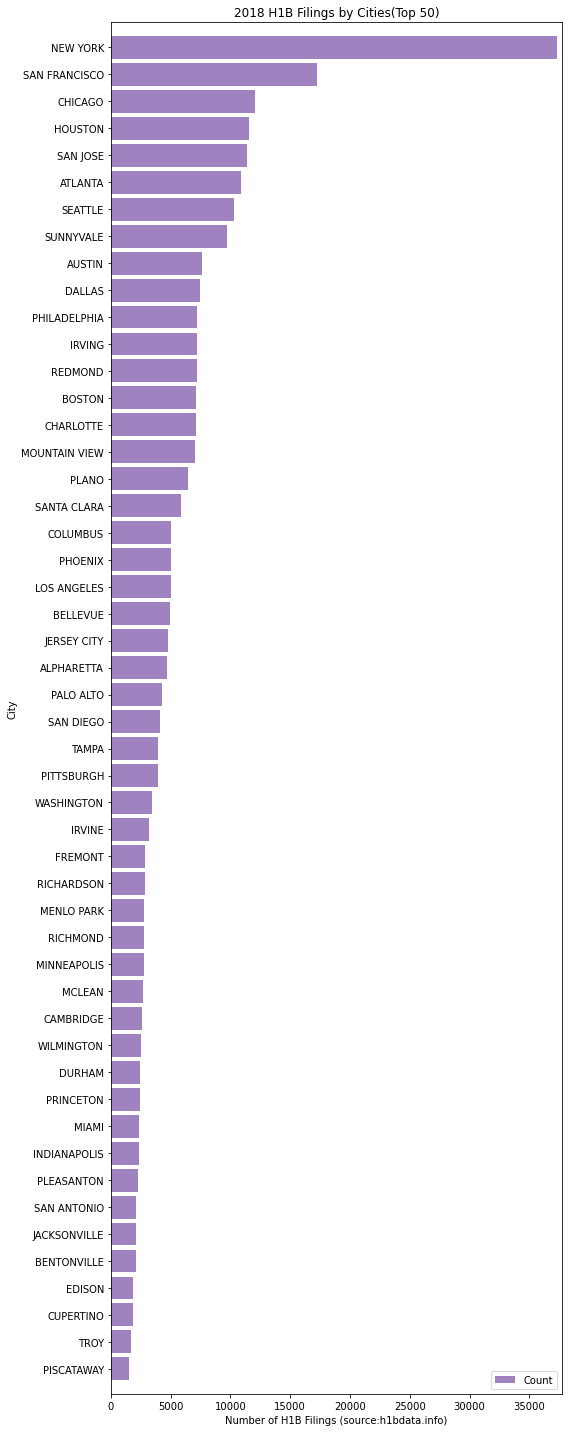

In [25]:
### Generate a bar plot, plot top 100
plt.figure(figsize = (8,20))
plt.barh(city_summary['city'], city_summary['count'], color = '#9F82C0',height = 0.85, label ='Count')
plt.gca().invert_yaxis() # Invert axis
plt.margins(0.01) # Adjust margins
plt.xlabel('Number of H1B Filings (source:h1bdata.info)')
plt.ylabel('City')
plt.title('2018 H1B Filings by Cities(Top 50)')
plt.legend() # Show legend
plt.tight_layout()
plt.savefig('images/cities', dpi = 300)
plt.show()

#### Job Titles

In [26]:
# Top job titles in 2018(LCA applicants number)
job_summary = (dat_content1
 .groupby('job_title_clean')
 .size()
 .sort_values(ascending = False)
 .reset_index()
 .rename(columns = {0: 'count'})
)
job_summary

job_title_clean  count
0                          SOFTWARE ENGINEER  20469
1                         SOFTWARE DEVELOPER  14705
2                   SENIOR SOFTWARE ENGINEER   4995
3                                 CONSULTANT   4090
4                         PROGRAMMER ANALYST   3864
...                                      ...    ...
46742  QA ENGINEER MEMBER OF TECHNICAL STAFF      1
46743                         QA ENGINEER IV      1
46744                        QA ENGINEER III      1
46745                  QA ENGINEER DEVELOPER      1
46746             NETWORK OPERATIONS ANALYST      1

[46747 rows x 2 columns]

In [27]:
# Put cleaned job titles into a long string for wordcloud generation
long_str = ''.join(job_summary.job_title_clean.tolist())

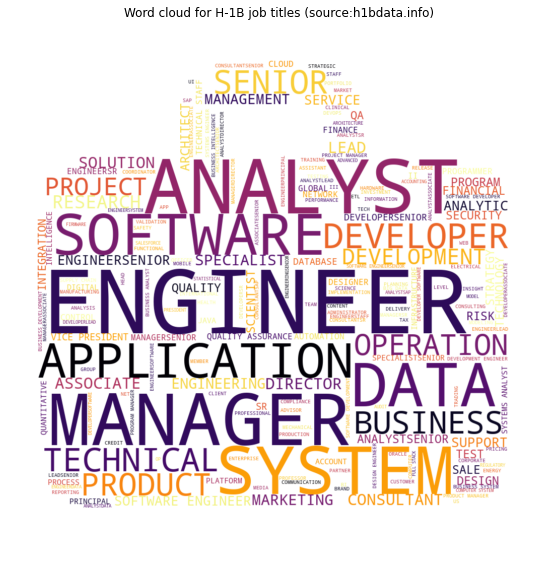

In [28]:
# Generate word cloud
h1b_mask = np.array(Image.open("./images/h1b.png"))
c = wordcloud.WordCloud(background_color = "white",
              width=736,
              height=715,
              colormap=plt.cm.inferno,
              mask = h1b_mask)
wc = c.generate(long_str)
plt.figure(figsize = (10,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Word cloud for H-1B job titles (source:h1bdata.info)')
plt.savefig('images/wordcloud', dpi = 300)
plt.show()

In [29]:
# Check job title contains "engineer"
job_engineer = job_summary[job_summary['job_title_clean'].str.contains("ENGINEER")] 
job_engineer

job_title_clean  count
0                          SOFTWARE ENGINEER  20469
2                   SENIOR SOFTWARE ENGINEER   4995
10          SOFTWARE DEVELOPMENT ENGINEER II   1893
19                                  ENGINEER   1286
24                          SYSTEMS ENGINEER   1092
...                                      ...    ...
46741  QA ENGINEER SOFTWARE ENGINEER IN TEST      1
46742  QA ENGINEER MEMBER OF TECHNICAL STAFF      1
46743                         QA ENGINEER IV      1
46744                        QA ENGINEER III      1
46745                  QA ENGINEER DEVELOPER      1

[10820 rows x 2 columns]

In [30]:
# See percentage (23%!!)
job_engineer.shape[0]/job_summary.shape[0]

0.23145870323229298

### 2. What’s the distribution of H-1B salary for those certified/ withdrawn/ denied LCAs in 2018? What’s the certified rate?

#### Case distribution

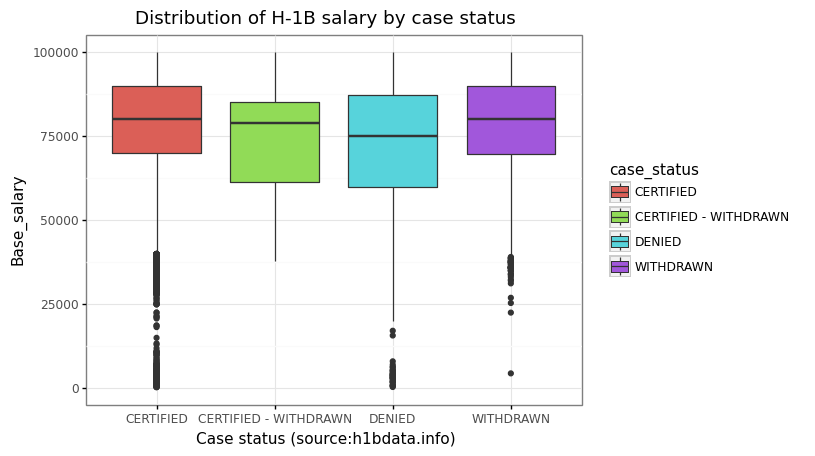

<ggplot: (8765982220322)>

In [31]:
# Plot salary distribution
p= (
    ggplot(dat_content1) +
    geom_boxplot(aes(dat_content1.case_status,dat_content1.base_salary,fill=dat_content1.case_status)) +
    ylim(0,100000)+
    theme(figure_size = (10,8))+
    theme_bw()+
    labs(title = "Distribution of H-1B salary by case status",
         x = 'Case status (source:h1bdata.info)',
         y = 'Base_salary')
)
ggsave(p, "images/h1b_salary_dist.png")
p

#### Certified rate

In [32]:
# Plot case status in percentage
# Count
p = (dat_content1
 .groupby('case_status')
 .size()
 .reset_index()
 .rename(columns = {0: 'count'})
)

In [33]:
# Percentage
p['percentage'] = (p['count']/dat_content1.shape[0]*100)

In [34]:
p

case_status   count  percentage
0              CERTIFIED  277547   95.749775
1  CERTIFIED - WITHDRAWN     444    0.153174
2                 DENIED    3493    1.205035
3              WITHDRAWN    8383    2.892016

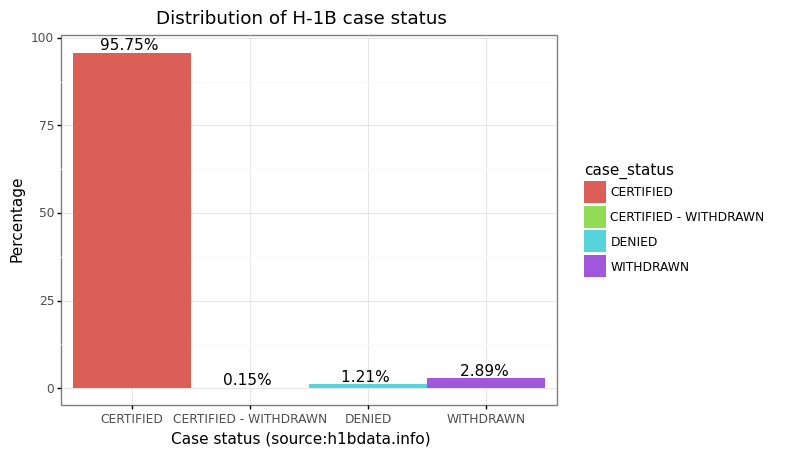

<ggplot: (8765973424900)>

In [35]:
# Plot certified rate
fg= (
    ggplot(p, aes(x='case_status', y='percentage', fill='case_status'))+
    geom_bar(width = 1, stat = "identity")+
    geom_text(aes(label = 'percentage'),
              nudge_y=0.125,
              va='bottom',
              format_string='{:.2f}% ')+
    theme_bw()+
    labs(title = "Distribution of H-1B case status",
         x = 'Case status (source:h1bdata.info)',
         y = 'Percentage')
)
ggsave(fg, "images/case_dist.png")
fg

### 3.Distribution of length of preparation period (submit – start)

In [36]:
###Create "n_days"
dat_content2 = dat_content1.copy()
    # split effective column
dat_content2['start_date'] = dat_content2['start_date'].astype("datetime64")
    # create start date
dat_content2['submit_date'] = dat_content2['submit_date'].astype("datetime64")
    # create end date
dat_content2['n_days'] = dat_content2['start_date'] - dat_content2['submit_date'] + timedelta(days=1)
    #Calculate preparation periods
dat_content2['n_days'] = dat_content2['n_days'].astype("string").replace('NaT','0')
    # Brush up, change data type to string and replace "NaT" with "0"
dat_content2['n_days'] = dat_content2['n_days'].str.split().str[0].astype('int')
    # Brush up, extract the number of days and change them to integer

In [37]:
# See result
dat_content2

employer  base_salary      location submit_date  \
0          BARCLAYS SERVICES CORP       125000  NEW YORK, NY  2018-06-13   
1                        VLINKINC        85000  NEW YORK, NY  2018-12-13   
2                        VLINKINC        85000  NEW YORK, NY  2018-12-20   
3             DIGITAL SCRIPTS INC        92700  NEW YORK, NY  2018-11-12   
4             DIGITAL SCRIPTS INC        92800  NEW YORK, NY  2018-08-30   
...                           ...          ...           ...         ...   
1693    ENTREGA SYSTEMS GROUP INC        62000      TROY, MI  2018-03-30   
1694                BROADGATE INC        60000      TROY, MI  2018-02-20   
1695                     ELIX INC        71635      TROY, MI  2018-03-30   
1696  PRECISION TECHNOLOGIES CORP        61420      TROY, NY  2018-04-17   
1697     WEBASTO ROOF SYSTEMS INC       100693      TROY, MI  2018-09-20   

     start_date case_status      city                      job_title_clean  \
0    2018-07-02   CERTIFIED  NEW YORK  NET QLIK DEVELOPER SYSTEMS ENGINEER   
1    2018-12-26   WITHDRAWN  NEW YORK                        NET ARCHITECT   
2    2019-01-03   CERTIFIED  NEW YORK                        NET ARCHITECT   
3    2018-12-28   CERTIFIED  NEW YORK                        NET DEVELOPER   
4    2018-12-28   CERTIFIED  NEW YORK                        NET DEVELOPER   
...         ...         ...       ...                                  ...   
1693 2018-09-08   CERTIFIED      TROY            WEB APPLICATION DEVELOPER   
1694 2018-03-01   CERTIFIED      TROY                        WEB DEVELOPER   
1695 2018-09-28   CERTIFIED      TROY                        WEB DEVELOPER   
1696 2018-04-17   CERTIFIED      TROY                WINDOWS ADMINISTRATOR   
1697 2018-10-01   CERTIFIED      TROY                          WPS MANAGER   

      n_days  
0         20  
1         14  
2         15  
3         47  
4        121  
...      ...  
1693     163  
1694      10  
1695     183  
1696       1  
1697      12  

[289867 rows x 9 columns]

In [38]:
### Start a connection to SQLite
conn = sqlite3.connect("Data/h1bdata.sqlite")

In [39]:
### Save data frames to a sqlite data base (with cleaned data and preparation days)
dat_content2.to_sql(name="cleaned_LCA2018",con=conn,index=False)

In [40]:
### Smaller data frame for plot
n_prep = dat_content2.loc[:, ['submit_date','start_date','n_days']]

In [41]:
### Calculate mean
mean = n_prep['n_days'].mean()

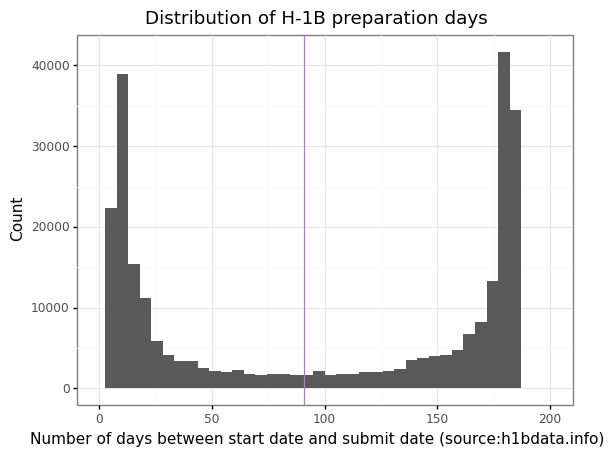

<ggplot: (8765973424878)>

In [42]:
### Plot preparation days' distribution
p= (
    ggplot(n_prep, aes('n_days'))+
    geom_histogram()+
    xlim(0,200)+
    geom_vline(xintercept = mean, color ='#9F82C0')+
    theme_bw()+
    labs(title = "Distribution of H-1B preparation days",
     x = 'Number of days between start date and submit date (source:h1bdata.info)',
     y = 'Count')
)
ggsave(p, "images/prep_dist.png")
p

### 4.What positions have the highest median salaries among certified LCAs
- Not specifying applicant number?
- applicants >10?

In [43]:
# Filter certified
certified_LCA = dat_content2[dat_content2['case_status']=='CERTIFIED']

In [44]:
# See results
certified_LCA

employer  base_salary      location submit_date  \
0          BARCLAYS SERVICES CORP       125000  NEW YORK, NY  2018-06-13   
2                        VLINKINC        85000  NEW YORK, NY  2018-12-20   
3             DIGITAL SCRIPTS INC        92700  NEW YORK, NY  2018-11-12   
4             DIGITAL SCRIPTS INC        92800  NEW YORK, NY  2018-08-30   
6               POPULUS GROUP LLC       144000  NEW YORK, NY  2018-07-02   
...                           ...          ...           ...         ...   
1693    ENTREGA SYSTEMS GROUP INC        62000      TROY, MI  2018-03-30   
1694                BROADGATE INC        60000      TROY, MI  2018-02-20   
1695                     ELIX INC        71635      TROY, MI  2018-03-30   
1696  PRECISION TECHNOLOGIES CORP        61420      TROY, NY  2018-04-17   
1697     WEBASTO ROOF SYSTEMS INC       100693      TROY, MI  2018-09-20   

     start_date case_status      city                      job_title_clean  \
0    2018-07-02   CERTIFIED  NEW YORK  NET QLIK DEVELOPER SYSTEMS ENGINEER   
2    2019-01-03   CERTIFIED  NEW YORK                        NET ARCHITECT   
3    2018-12-28   CERTIFIED  NEW YORK                        NET DEVELOPER   
4    2018-12-28   CERTIFIED  NEW YORK                        NET DEVELOPER   
6    2018-07-23   CERTIFIED  NEW YORK                        NET DEVELOPER   
...         ...         ...       ...                                  ...   
1693 2018-09-08   CERTIFIED      TROY            WEB APPLICATION DEVELOPER   
1694 2018-03-01   CERTIFIED      TROY                        WEB DEVELOPER   
1695 2018-09-28   CERTIFIED      TROY                        WEB DEVELOPER   
1696 2018-04-17   CERTIFIED      TROY                WINDOWS ADMINISTRATOR   
1697 2018-10-01   CERTIFIED      TROY                          WPS MANAGER   

      n_days  
0         20  
2         15  
3         47  
4        121  
6         22  
...      ...  
1693     163  
1694      10  
1695     183  
1696       1  
1697      12  

[277547 rows x 9 columns]

#### Not specifying applicant numebr

In [45]:
# Number of applicants
count = (certified_LCA
 .groupby('job_title_clean')
 .size()
 .reset_index()
 .rename(columns = {0: 'count'})
 .reset_index(drop=True)
)
count.describe()

count
count  46222.000000
mean       6.004651
std      126.645209
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max    19640.000000

In [46]:
# Median salary by job title
median_salary = (certified_LCA
 .groupby('job_title_clean')
 .base_salary
 .median()
 .reset_index()
 .rename(columns = {'base_salary': 'median_base_salary'})                
)
median_salary

job_title_clean  median_base_salary
0       ASSOCIATE PRODUCT DEVELOPMENT MANAGER             63500.0
1              INFORMATION TECHNOLOGY ANALYST             93000.0
2                               NET DEVELOPER             91000.0
3                                  09 01 2018             96500.0
4                                           1             85925.0
...                                       ...                 ...
46217            YIELD OPTIMIZATION ASSOCIATE             63336.0
46218                      YOUNG INVESTIGATOR              5962.0
46219         YOUNG PROFESSIONALS COORDINATOR             63003.0
46220   YOUTH DEVELOPMENT PROGRAM COORDINATOR             39460.0
46221      ZERO INVENTORY PROJECT ZIP ANALYST             61100.0

[46222 rows x 2 columns]

In [47]:
# Inner join with all certified
certified_all = pd.merge(left = count,
         right = median_salary,
         how = "inner",      # The type of join
         on = "job_title_clean") 

In [48]:
# Save the merged data frame to sql(with descending median salary)
(certified_all
 .sort_values('median_base_salary', ascending= False)
 .to_sql(name="certified_all",con=conn,index=False))

In [49]:
# Top 30 salary among all certified
certified_all_sort =(certified_all
                     .sort_values('median_base_salary', ascending= False)
                     .head(30).reset_index(drop = True))

In [50]:
# Save the result as png
fig =  ff.create_table(certified_all_sort)
fig.update_layout(
    autosize=False,
    width=1400,
    height=800,
)
fig.write_image("images/certified_all_sort.png", scale=2)
fig.show()

#### Applicants > 10

In [51]:
# Filter job title with count > 10
count_greater_10 = (certified_LCA
 .groupby('job_title_clean')
 .size()
 .reset_index()
 .rename(columns = {0: 'count'})
 .query('count > 10')
 .reset_index(drop=True)
)
count_greater_10.describe()

count
count   2002.000000
mean     102.438561
std      600.594033
min       11.000000
25%       15.000000
50%       24.000000
75%       54.000000
max    19640.000000

In [52]:
# Merge with median salary data frame
certified_greater10 = pd.merge(left = count_greater_10,
         right = median_salary,
         how = "inner",      # The type of join
         on = "job_title_clean") 

In [53]:
# Save the merged data frame to sql(with descending median salary)
(certified_greater10
 .sort_values('median_base_salary', ascending= False)
 .to_sql(name="certified_greater10",con=conn,index=False))

In [54]:
# Top 30 salary among certified with greater than 10 applicants
certified_greater10_sort = (certified_greater10
                            .sort_values('median_base_salary', ascending= False)
                            .head(30).reset_index(drop=True))

In [55]:
# Save the result as png
fig =  ff.create_table(certified_greater10_sort)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800
)
fig.write_image("images/certified_greater10_sort.png", scale = 2)
fig.show()

### 5. Explore the trend in Amazon over last 10 years. What's trend for median salary compared with number of applicants? What's the base salary distribution by each year?

#### Get data

In [56]:
# target url
url = "https://h1bdata.info/index.php?em=Amazon&job=&city=&year=All+Years"

In [57]:
# parse
page = requests.get(url)

In [58]:
# read table
if page.status_code == 200:
    df = pd.read_html(page.text)[0]

In [59]:
# see result
df

EMPLOYER                              JOB TITLE  \
0      AMAZON FULFILLMENT SERVICES INC                   AAP VERTICAL ANALYST   
1      AMAZON FULFILLMENT SERVICES INC                   AAP VERTICAL ANALYST   
2               AMAZONCOM SERVICES INC                   AAP VERTICAL ANALYST   
3               AMAZONCOM SERVICES INC                    ABA PARTNER MANAGER   
4               AMAZON MEDIA GROUP LLC                      ACCOUNT EXECUTIVE   
...                                ...                                    ...   
38130          AMAZON WEB SERVICES INC                  WORKSPACES CONSULTANT   
38131          AMAZON WEB SERVICES INC                  WORKSPACES CONSULTANT   
38132           AMAZONCOM SERVICES INC               WORLDWIDE DEMAND PLANNER   
38133           AMAZONCOM SERVICES INC              WW DESIGN PROGRAM MANAGER   
38134           AMAZONCOM SERVICES INC  WW REAL ESTATE DESIGN PROGRAM MANAGER   

       BASE SALARY             LOCATION SUBMIT DATE  START DATE CASE STATUS  
0            95000         NEW YORK, NY  10/30/2017  11/06/2017   CERTIFIED  
1            95000         NEW YORK, NY  10/27/2017  01/01/2018   CERTIFIED  
2            95000         NEW YORK, NY  02/22/2018  07/17/2018   CERTIFIED  
3           125000          SEATTLE, WA  02/07/2018  07/12/2018   CERTIFIED  
4           103600         NEW YORK, NY  03/09/2018  08/12/2018   CERTIFIED  
...            ...                  ...         ...         ...         ...  
38130       152000        SAN DIEGO, CA  06/22/2018  06/22/2018   CERTIFIED  
38131       152000      LOS ANGELES, CA  06/22/2018  06/22/2018   CERTIFIED  
38132       103000  SEATTLE, WASHINGTON  10/30/2019  12/02/2019   CERTIFIED  
38133       145000          SEATTLE, WA  09/09/2019  09/16/2019   CERTIFIED  
38134       145000          SEATTLE, WA  08/16/2019  08/26/2019   CERTIFIED  

[38135 rows x 7 columns]

In [60]:
# column name to lower-case letters
df.columns = [c.lower().replace(" ","_") for c in df.columns]

In [61]:
# extract the year
df['year'] = df['start_date'].str.split("/").str[-1]

In [62]:
# save the merged data frame to sql(with descending median salary)
df.to_sql(name="Amazon2012_2020",con=conn,index=False)

#### Count and median base salary

In [63]:
# get the count and median salary for each year
ap = (df.groupby('year')
.agg({'location':'size', 'base_salary': 'median'})
.rename(columns={'location':'applicants_count','base_salary':'median_base_salary'})
.reset_index()
)

In [64]:
# see result
ap

year  applicants_count  median_base_salary
0  2012                32              100550
1  2013                93              107800
2  2014               368              110000
3  2015              2324              110850
4  2016              3247              117000
5  2017              5058              120000
6  2018              6732              130000
7  2019              9969              134500
8  2020             10312              140000

In [65]:
# Save Amazon trend data to sql
ap.to_sql(name="Amazon_trend",con=conn,index=False)

In [66]:
# change the year column type for easier plot
ap.year = ap.year.astype('int')

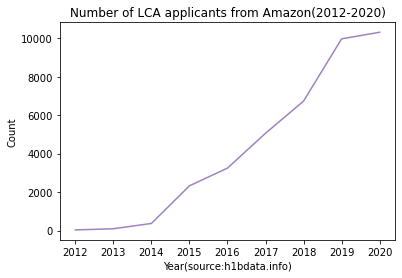

In [67]:
### Generate a line plot for number of applicants
plt.plot(ap.year, ap.applicants_count, color ='#9F82C0')
plt.xlabel('Year(source:h1bdata.info)')
plt.ylabel('Count')
plt.title('Number of LCA applicants from Amazon(2012-2020)')
plt.savefig('images/amazon_count', dpi = 300)
plt.show()

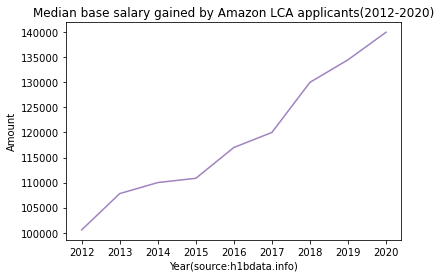

In [68]:
### Generate a line plot for base salary
plt.plot(ap.year,ap.median_base_salary, color ='#9F82C0')
plt.xlabel('Year(source:h1bdata.info)')
plt.ylabel('Amount')
plt.title('Median base salary gained by Amazon LCA applicants(2012-2020)')
plt.savefig('images/amazon_salary', dpi = 300)
plt.show()

#### Salary distribution by year

In [69]:
# plot distribution for base salary by year
D = df[['year','base_salary']]
p= (
    ggplot(D,aes(x='base_salary')) +
    geom_histogram() +
    facet_wrap('year',scales='free') +
    xlim(0,250000)+
    theme(figure_size=(18,8)
          ,subplots_adjust={'wspace':0.25, 'hspace':0.25})+
    labs(y="Number of applicants",
         x="Base Salary",
         title = 'Base salary distribution by year for Amazon LCA applicants(2012-2020)')
)

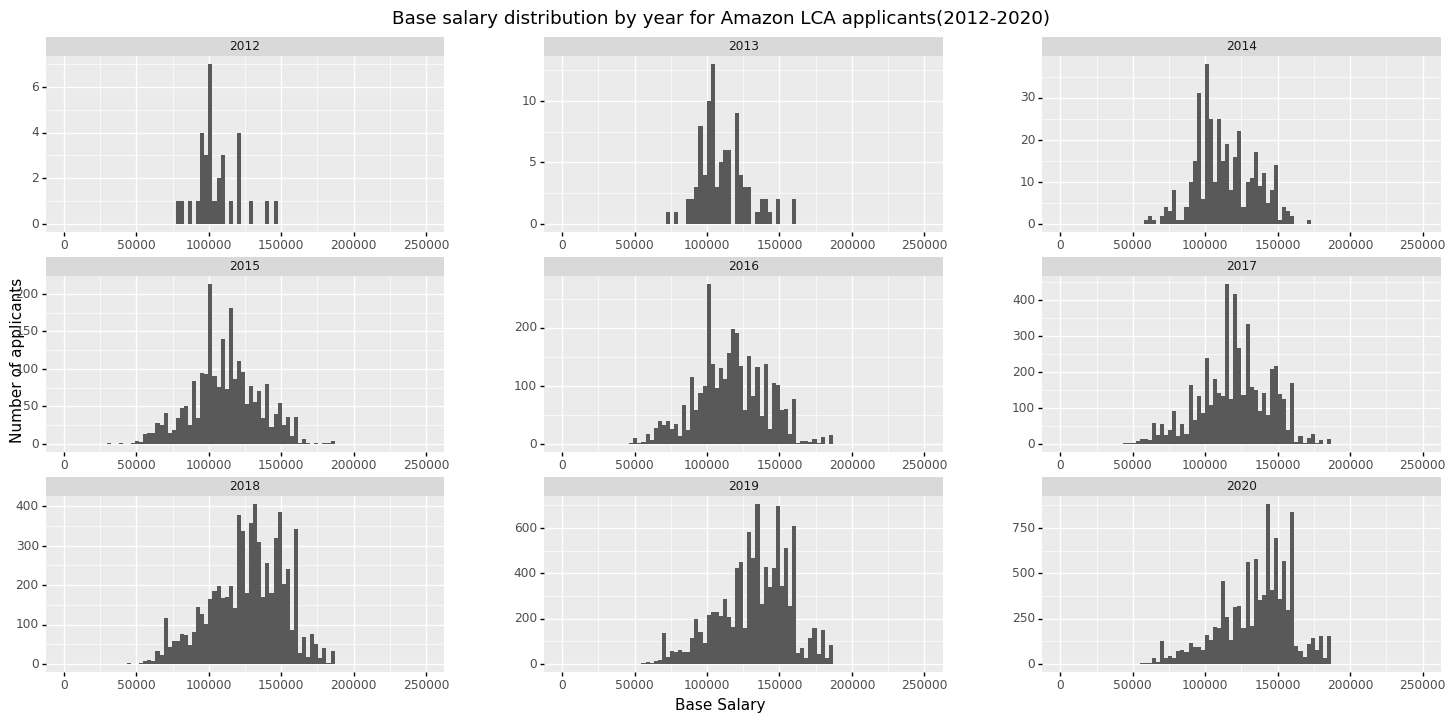

<ggplot: (8765978816449)>

In [70]:
ggsave(p, "images/salary_dist.png")
p

### 6. Examine the factors that are predictive of an applicant obtaining LCA certification?
- top companies?
- base_salary?
- job_titles?
- tech industry?
- preparation time?

#### Data Processing

#### `top100`

Top companies

In [71]:
# create a list for top 100 company
top100_list = company_summary['employer'].to_list()

In [72]:
# create dummy if company for each applicant is in the top 100 list
empin100 =[]
for e in dat_content2['employer']:
    empin100.append(1*(e in top100_list))
dat_content2['top100'] = empin100

In [73]:
# check result
dat_content2.top100.value_counts()

0    177708
1    112159
Name: top100, dtype: int64

#### `job20`

In [74]:
# extract word frequency dictionary for job title column
word_freq_dict = wordcloud.WordCloud().process_text(long_str)

In [75]:
# unpack dictionary
word_freq = pd.DataFrame(word_freq_dict.items(), columns=['word', 'frequency'])

In [76]:
# top 20 words in job title column as a list
popular20_list = (word_freq
                  .sort_values('frequency', ascending = False)
                  .head(20)
                  .word
                  .to_list()
                 )

In [77]:
# see result
popular20_list

['ENGINEER',
 'ANALYST',
 'MANAGER',
 'SYSTEM',
 'DATA',
 'SOFTWARE',
 'APPLICATION',
 'DEVELOPER',
 'TECHNICAL',
 'SENIOR',
 'BUSINESS',
 'PRODUCT',
 'OPERATION',
 'PROJECT',
 'DEVELOPMENT',
 'RESEARCH',
 'CONSULTANT',
 'SOLUTION',
 'ASSOCIATE',
 'LEAD']

In [78]:
# create dummy that any word in the job title matches at least one word in the top 20 list
titlein20 =[]
for j in dat_content2['job_title_clean']: 
    temp = []
    for jsplit in j.split():
        temp.append(jsplit in popular20_list)
    titlein20.append(1*any(temp))
dat_content2['job20'] = titlein20

In [79]:
# l =[]
# te = dat_content2.sample(5)
# for j in te['job_title_clean']:
#     temp = []
#     for jsplit in j.split():
#         temp.append(jsplit in popular10_list)
#     l.append(1*any(temp))
# print(l)

In [80]:
# te

In [81]:
# see result
dat_content2.job20.value_counts()

1    245108
0     44759
Name: job20, dtype: int64

In [82]:
# check columns
dat_content2.columns

Index(['employer', 'base_salary', 'location', 'submit_date', 'start_date',
       'case_status', 'city', 'job_title_clean', 'n_days', 'top100', 'job20'],
      dtype='object')

#### `job_tech`

In [83]:
### wordcloud frequency to get a sense of the job title data
(word_freq
 .sort_values('frequency', ascending = False)
 .head(200)
 .word
 .to_list())

['ENGINEER',
 'ANALYST',
 'MANAGER',
 'SYSTEM',
 'DATA',
 'SOFTWARE',
 'APPLICATION',
 'DEVELOPER',
 'TECHNICAL',
 'SENIOR',
 'BUSINESS',
 'PRODUCT',
 'OPERATION',
 'PROJECT',
 'DEVELOPMENT',
 'RESEARCH',
 'CONSULTANT',
 'SOLUTION',
 'ASSOCIATE',
 'LEAD',
 'DIRECTOR',
 'SPECIALIST',
 'MARKETING',
 'ENGINEERING',
 'MANAGEMENT',
 'SOFTWARE ENGINEER',
 'SERVICE',
 'ENGINEERSENIOR',
 'SUPPORT',
 'ANALYTIC',
 'ARCHITECT',
 'PROGRAM',
 'SALE',
 'STRATEGY',
 'DESIGN',
 'TEST',
 'SECURITY',
 'RISK',
 'ANALYSTSENIOR',
 'TECHNOLOGY',
 'FINANCIAL',
 'QUALITY',
 'SCIENTIST',
 'QA',
 'INTEGRATION',
 'VICE PRESIDENT',
 'SR',
 'DATABASE',
 'DEVELOPERSENIOR',
 'QUALITY ASSURANCE',
 'MANAGERSENIOR',
 'GLOBAL',
 'ENGINEERSR',
 'TECHNICAL STAFF',
 'CLOUD',
 'NETWORK',
 'AUTOMATION',
 'DESIGNER',
 'PROGRAMMER',
 'II',
 'CONTROL',
 'FINANCE',
 'INFRASTRUCTURE',
 'DIGITAL',
 'PRINCIPAL',
 'JAVA',
 'PROCESS',
 'SPECIALISTSENIOR',
 'SYSTEMS ANALYST',
 'QUANTITATIVE',
 'ACCOUNT',
 'INTELLIGENCE',
 'DEVELOPMENT

In [84]:
# a list of words indicate technology industry
tech_list = ['ENGINEER',
 'ANALYST',
 'SYSTEM',
 'DATA',
 'SOFTWARE',
 'APPLICATION',
 'DEVELOPER',
 'TECHNICAL',
 'ENGINEERING',
 'TECHNOLOGY',
 'DATABASE',
 'DEVELOPERSENIOR',
 'DEVELOPMENT',
 'ENGINEERSR',
 'TECHNICAL STAFF',
 'CLOUD',
 'NETWORK',
 'PROGRAMMER',
 'WEB']

In [85]:
# create dummy that any word in the job title matches at least one word in the tech list
jobintech =[]
for j in dat_content2['job_title_clean']: 
    temp = []
    for jsplit in j.split():
        temp.append(jsplit in tech_list)
    jobintech.append(1*any(temp))
dat_content2['job_tech'] = jobintech

In [86]:
dat_content2.job_tech.value_counts()

1    192033
0     97834
Name: job_tech, dtype: int64

In [87]:
# `city5` (NO influence, abandoned): Top cities

# top5_list = city_summary['city'].head(5).to_list()

# top5_list
# citin5 =[]
# for c in dat_content2['city']:
#     citin10.append(1*(c in top5_list))
# dat_content2['city5'] = citin5

# dat_content2.city5.value_counts()

#dat_content2

In [88]:
# select features for machine learning
dat_ml = dat_content2[['case_status','base_salary','n_days','top100','job20','job_tech']]

#### `case_status`

In [89]:
# convert case status to dummy
dat_ml['case_status'] = 1*(dat_ml['case_status']=='CERTIFIED')

In [90]:
# case status value counts
dat_ml.case_status.value_counts()

1    277547
0     12320
Name: case_status, dtype: Int64

In [91]:
# data frame for machine learning
dat_ml

case_status  base_salary  n_days  top100  job20  job_tech
0               1       125000      20       1      1         1
1               0        85000      14       0      0         0
2               1        85000      15       0      0         0
3               1        92700      47       0      1         1
4               1        92800     121       0      1         1
...           ...          ...     ...     ...    ...       ...
1693            1        62000     163       0      1         1
1694            1        60000      10       0      1         1
1695            1        71635     183       0      1         1
1696            1        61420       1       0      0         0
1697            1       100693      12       0      1         0

[289867 rows x 6 columns]

In [92]:
# Save the machine learning data frame(original) to sql
dat_ml.to_sql(name="dat_ml_ogsize",con=conn,index=False)

#### Machine Learning(Classification Task)

In [93]:
# make of copy of machine learning data frame
dat = dat_ml.copy().reset_index(drop =True)

In [94]:
# import resample for downsample majority
from sklearn.utils import resample

In [95]:
# Separate majority and minority classes
dat_majority = dat[dat.case_status==1]
dat_minority = dat[dat.case_status==0]
 
# Downsample majority class
dat_majority_downsampled = resample(dat_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=12320,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
dat_downsampled = pd.concat([dat_majority_downsampled, dat_minority])
 
# Display new class counts
dat_downsampled.case_status.value_counts()

0    12320
1    12320
Name: case_status, dtype: Int64

In [96]:
# result after downsampling
dat_downsampled

case_status  base_salary  n_days  top100  job20  job_tech
218051            1       105000      27       0      1         1
27562             1       180000      20       0      1         0
186654            1        87797     183       0      1         1
189154            1        98960       2       1      1         0
240422            1        76925     184       1      1         1
...             ...          ...     ...     ...    ...       ...
289766            0       100000      43       0      1         1
289783            0        66000       8       1      1         1
289786            0        79540     184       0      1         1
289810            0        52880     178       0      1         1
289823            0        80000     174       0      0         1

[24640 rows x 6 columns]

In [97]:
# Save the machine learning data frame(downsampled) to sql
dat_downsampled.to_sql(name="dat_ml_downsampled",con=conn,index=False)

In [98]:
# check data types
dat_downsampled.dtypes

case_status    Int64
base_salary    int64
n_days         int64
top100         int64
job20          int64
job_tech       int64
dtype: object

In [99]:
# set dummy
for col in ['case_status','top100', 'job20', 'job_tech']:
    dat_downsampled[col] = dat_downsampled[col].astype('category').astype('int')

#### Explore the train set

In [100]:
# target/feature, train/test split
y = dat_downsampled[['case_status']]
X = dat_downsampled.drop(columns=['case_status'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

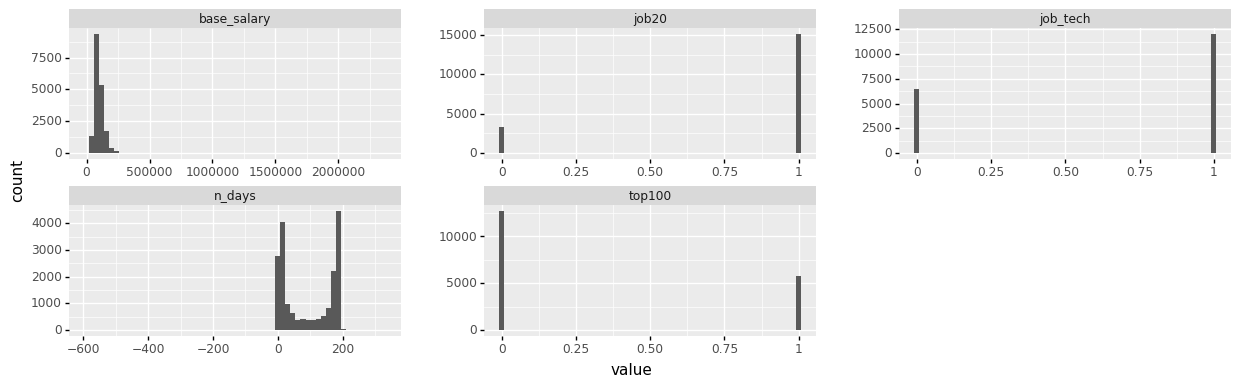

<ggplot: (8765997694877)>

In [101]:
# plot the continuous Variables 
d = train_X.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=60) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,4),
          subplots_adjust={'wspace':0.25, 'hspace':0.35})
)

In [102]:
# Explore base salary outliers
dat_downsampled.base_salary.describe()

count    2.464000e+04
mean     1.012164e+05
std      4.709757e+04
min      3.640000e+02
25%      7.583700e+04
50%      9.281000e+04
75%      1.186375e+05
max      2.360000e+06
Name: base_salary, dtype: float64

In [103]:
# Focus on annual salary <= 500000
dat_downsampled = dat_downsampled[dat_downsampled.base_salary <= 500000 ]

In [104]:
# check salary <= 500000
dat_downsampled.base_salary.describe()

count     24615.000000
mean     100382.288442
std       37554.363331
min         364.000000
25%       75837.000000
50%       92800.000000
75%      118456.000000
max      500000.000000
Name: base_salary, dtype: float64

#### Resplit

In [105]:
# resplit data set after limiting salary range
y = dat_downsampled[['case_status']]
X = dat_downsampled.drop(columns=['case_status'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [106]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

In [107]:
# build a pipe to standardize
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [108]:
# model candidates
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]

In [109]:
#Put it all together in a GridSearch
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc')

In [110]:
# Run models
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=4,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [111]:
# Best ROC AUC score
search.best_score_

0.6263007193705119

In [112]:
# Best Model
search.best_params_

{'model': RandomForestClassifier(max_depth=4, n_estimators=1500),
 'model__max_depth': 4,
 'model__n_estimators': 1500}

In [113]:
# random forest model wins
rf_mod = search.best_estimator_

#### Performance(training set)
Let's look at performance on training set.

In [114]:
train_pred_y = rf_mod.predict(train_X)
train_pred_y_proba = rf_mod.predict_proba(train_X)[:,1]

In [115]:
m.mean_squared_error(train_y,train_pred_y)

0.4083744109203185

In [116]:
m.accuracy_score(train_y,train_pred_y)

0.5916255890796814

In [117]:
m.roc_auc_score(train_y,train_pred_y_proba)

0.632489755938992

#### Performance(test set)
Let's look at performance on test set.

In [118]:
pred_y = rf_mod.predict(test_X)
pred_y_proba = rf_mod.predict_proba(test_X)[:,1]

In [119]:
m.mean_squared_error(test_y,pred_y)

0.4080272993175171

In [120]:
m.accuracy_score(test_y,pred_y)

0.591972700682483

In [121]:
m.roc_auc_score(test_y,pred_y_proba)

0.6249324395335807

In [122]:
print(m.classification_report(test_y,pred_y))

              precision    recall  f1-score   support

           0       0.57      0.78      0.66      3099
           1       0.64      0.40      0.49      3055

    accuracy                           0.59      6154
   macro avg       0.61      0.59      0.58      6154
weighted avg       0.61      0.59      0.58      6154



In [123]:
# see predicts (how many certified vs. uncertified as predicted)
(unique, counts)= np.unique(pred_y, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 4246]
 [   1 1908]]


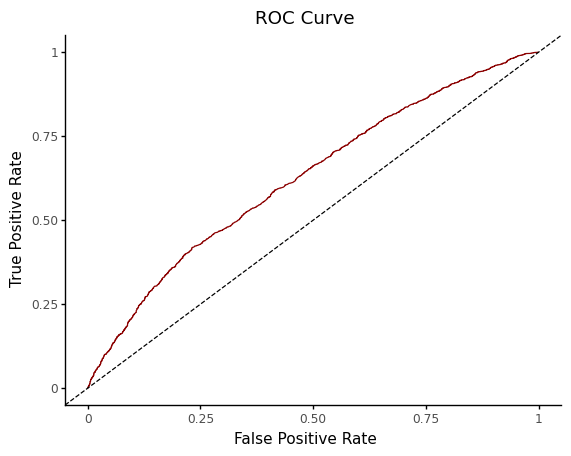

<ggplot: (8765974942826)>

In [124]:
# roc auc curve
fpr,tpr,thres = m.roc_curve(test_y,pred_y_proba)

p= (
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="darkred") +
    geom_abline(linetype="dashed") +
    theme_classic() +
    labs(y="True Positive Rate",x="False Positive Rate", title = 'ROC Curve')
)
ggsave(p, "images/roc_auc.png")
p

For the most predictive model, do the following:
- (a) Examine the variable importance, which three variables does the model rely on most when making predictions?
- (b) Plot partial dependency plots for the top three most important variable. What does the marginal relationship tell you?
- (c) Plot an ICE plot for the most important variable. Is there any heterogeneity in the marginal effect across observations? If so, what might this mean?

#### Permutation

In [125]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=5)

In [126]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

vi_dat

variable        vi       std       low      high
0       top100  0.092129  0.003283  0.085563  0.098695
1       n_days  0.001473  0.000210  0.001054  0.001892
2  base_salary  0.000206  0.000093  0.000019  0.000392
3        job20 -0.000033  0.000027 -0.000086  0.000021
4     job_tech -0.000043  0.000041 -0.000124  0.000038

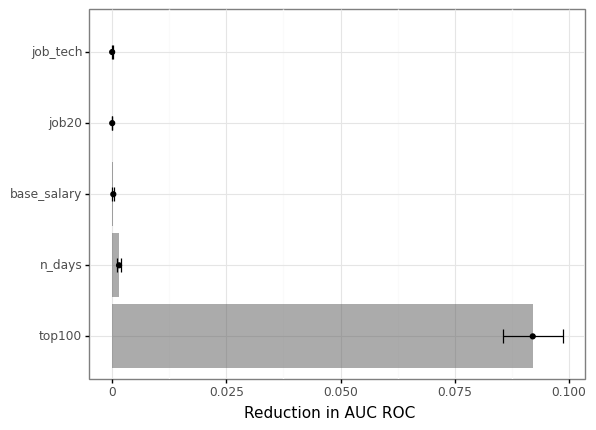

<ggplot: (8765973813396)>

In [127]:
# plot permutation result
p= (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)
ggsave(p, "images/permutation.png")
p

#### PDP Plot

In [128]:
# interaction 1: top100 and base salary
inter1  =  pdp.pdp_interact(model = rf_mod, 
                            dataset = train_X,
                            model_features = train_X.columns,
                            features=["top100",'base_salary'])

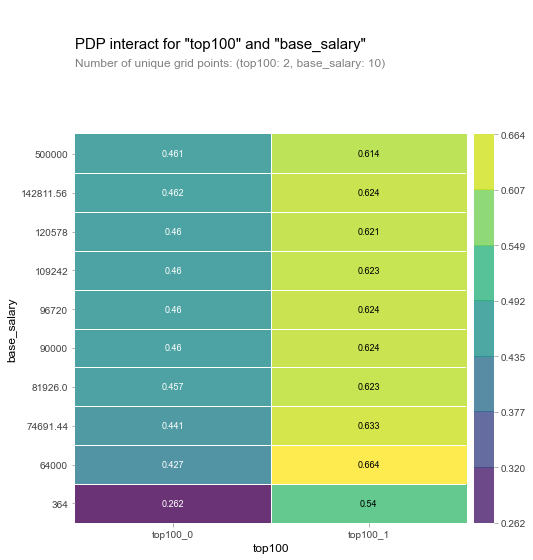

In [129]:
# plot interaction1
fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                               feature_names=["top100",'base_salary'],
                               plot_type="grid")
pdp.plt.savefig('images/inter1.png', dpi=200)

In [130]:
# interaction 2: top100 and job_tech
inter2  =  pdp.pdp_interact(model = rf_mod, 
                            dataset = train_X,
                            model_features = train_X.columns,
                            features=["top100",'job_tech'])

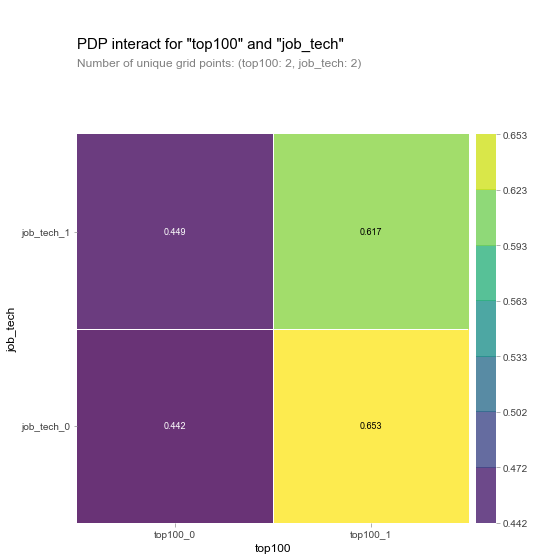

In [131]:
# plot interaction2
fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter2, 
                               feature_names=["top100",'job_tech'],
                               plot_type="grid")
pdp.plt.savefig('images/inter2.png', dpi=200)

#### ICE Plot

In [132]:
# Define a function to generate centered ICE plot
def gen_ice_plot_c(var_name = "top100"):
    try:
        pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                                   dataset = train_X,
                                   model_features = train_X.columns.tolist(),
                                   feature=var_name)

        fig,ax = pdp.pdp_plot(pdp_dist,var_name,plot_pts_dist=True,
                              center=True,plot_lines=True)
    except:
        print("") # Dependency issue

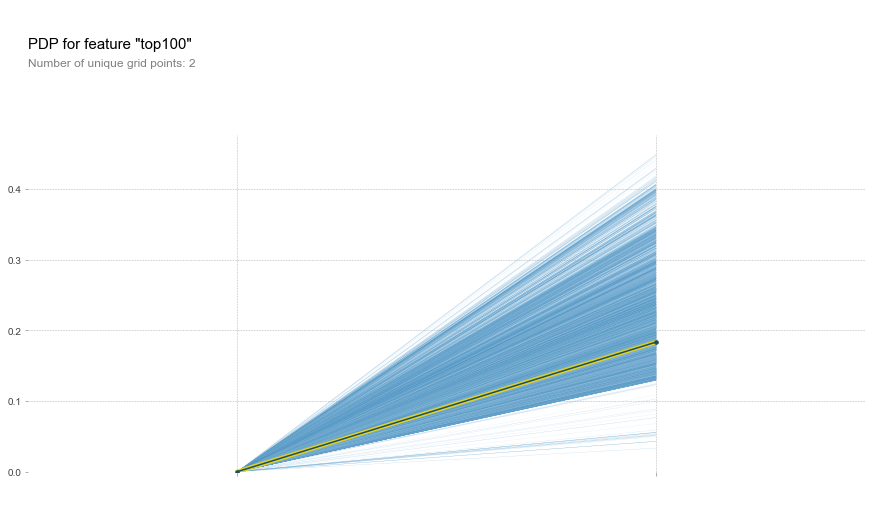

In [133]:
# Apply on "top100"
gen_ice_plot_c(var_name = "top100")
pdp.plt.savefig('images/ice.png', dpi=200)

#### Global Surrogate Models

In [134]:
# Generate a vector of predictions (specifically, predicted probabilities since this is a classification problem)
pr_y = rf_mod.predict_proba(train_X)[:,rf_mod.classes_ == 1]
pr_y

array([[0.4022951 ],
       [0.46306152],
       [0.45877328],
       ...,
       [0.3664021 ],
       [0.61394327],
       [0.39456632]])

In [144]:
# Fit the surrogate model on the predictions
surrogate_model = DT_reg(max_depth=3)
surrogate_model.fit(train_X,pr_y)

DecisionTreeRegressor(max_depth=3)

In [145]:
# Calculate R^2
m.r2_score(pr_y,surrogate_model.predict(train_X)).round(2)

0.96

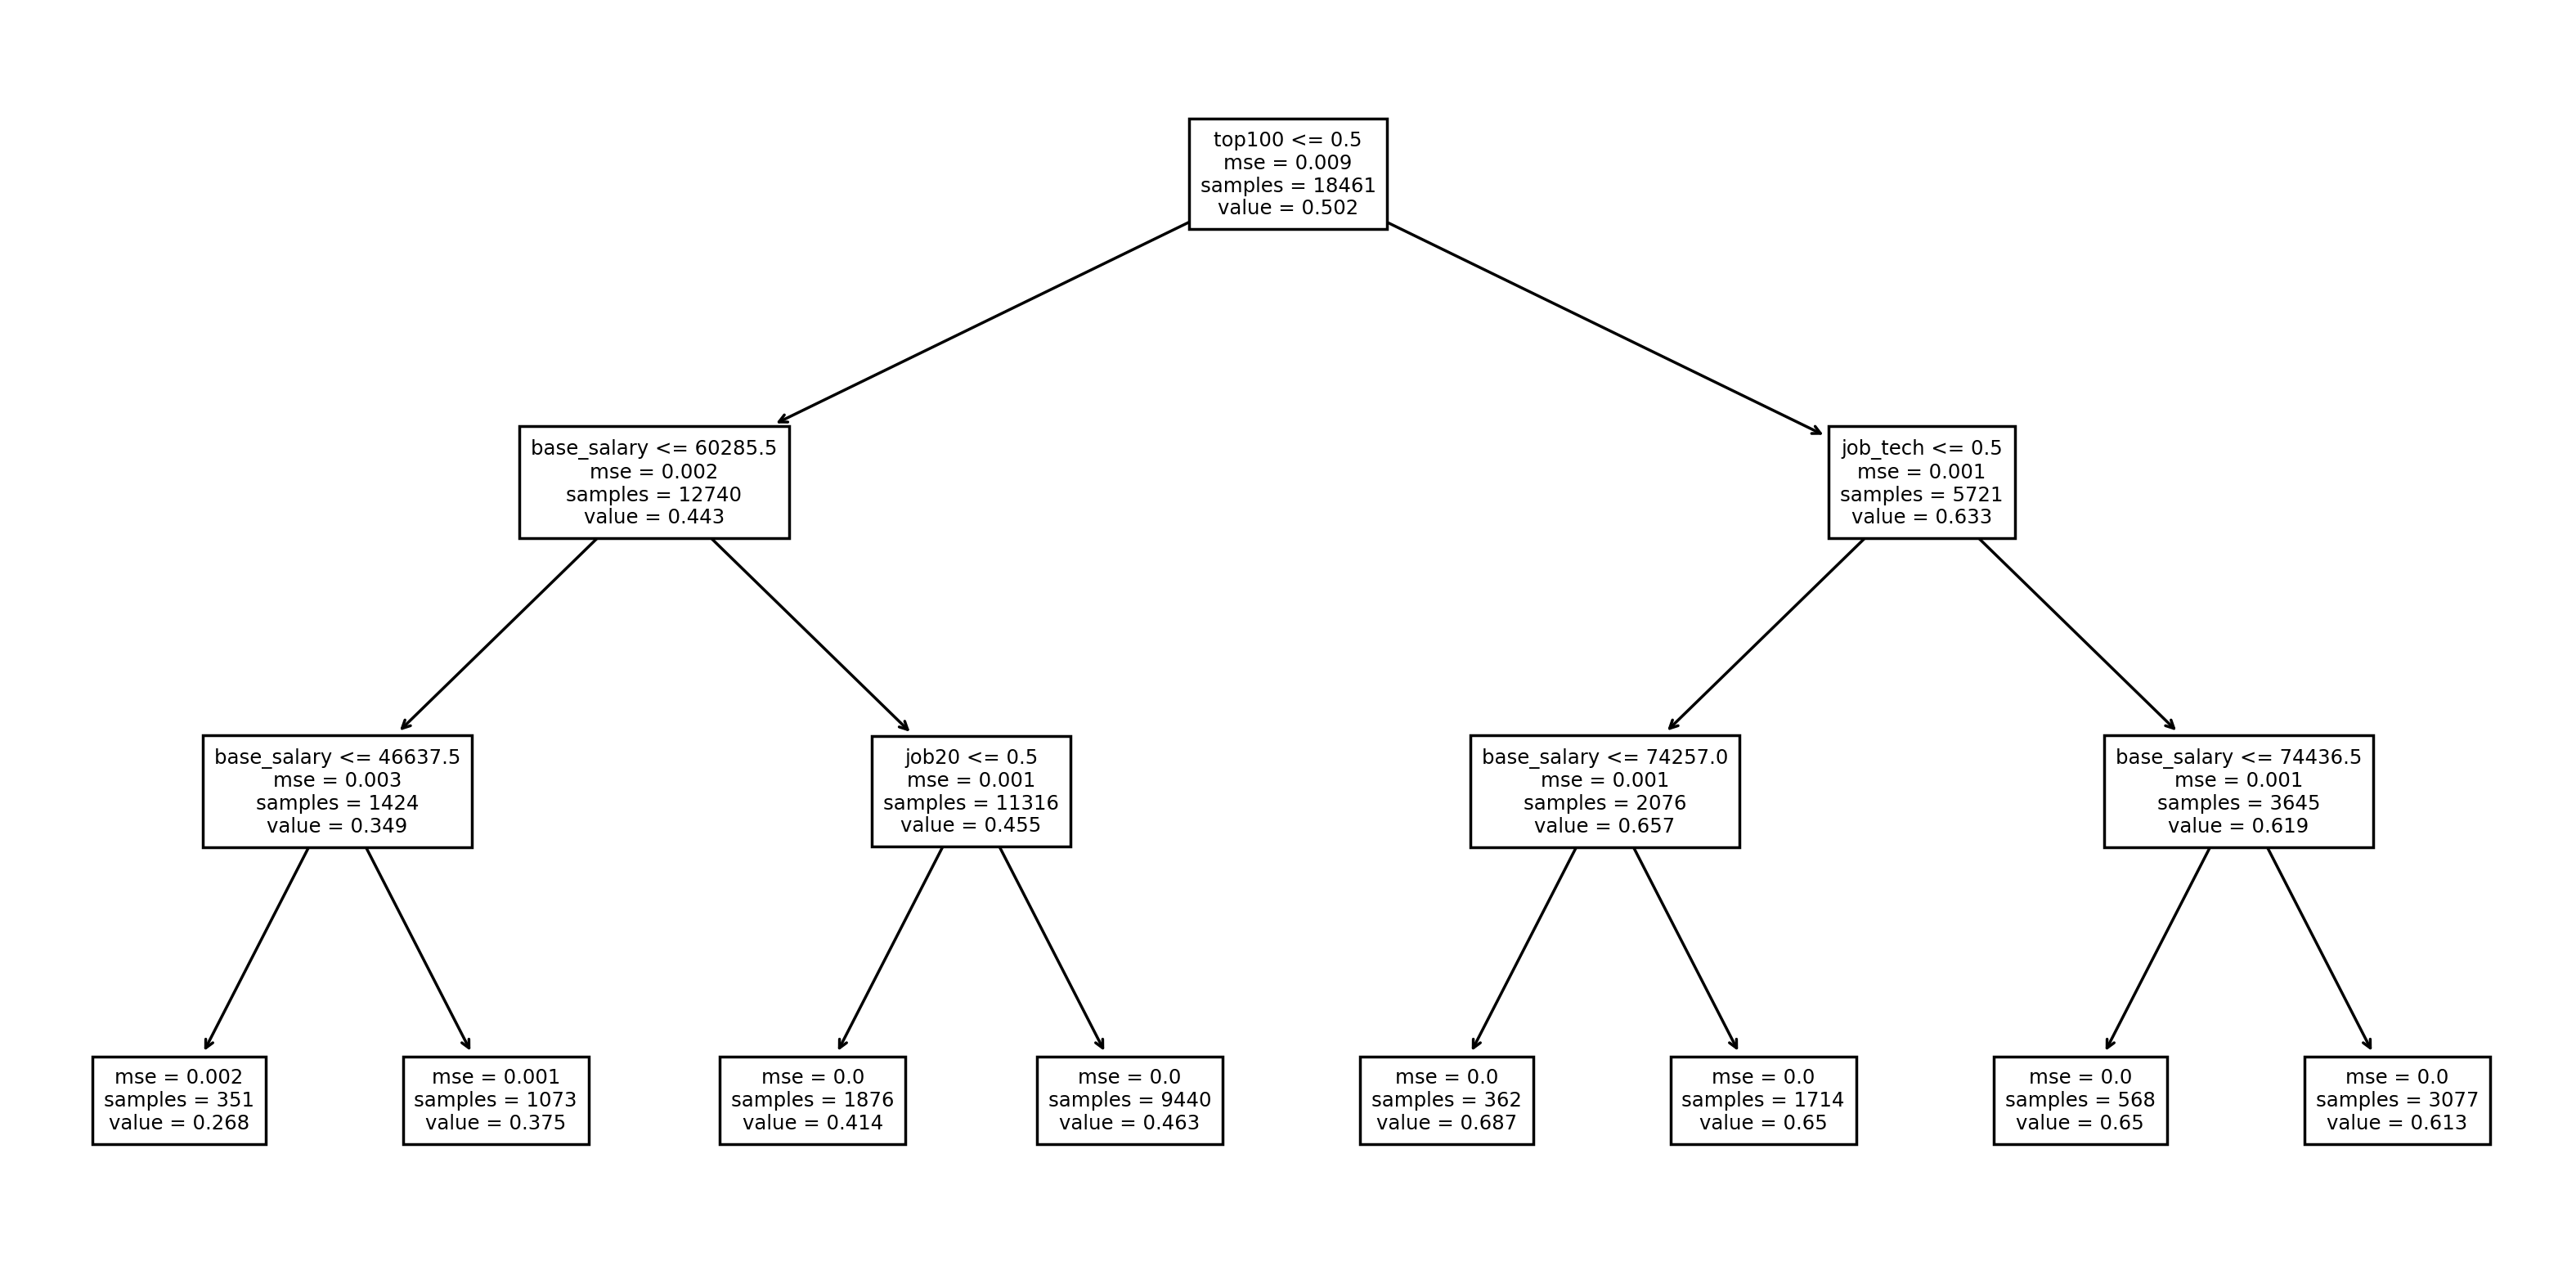

In [147]:
# Plot the tree
plt.figure(figsize=(16,8),dpi=250)
rules = tree.plot_tree(surrogate_model,feature_names=train_X.columns,fontsize=7)
plt.savefig('images/tree', dpi = 300)

In [138]:
# query applicants with best chance according to the tree, see top 10 jobs with most applicants
best_chance_nontech = (dat_content2
 .query('top100>0.5')
 .query('job_tech<=0.5')
 .query('base_salary<=74257')
 .groupby('job_title_clean')
 .size()
 .sort_values(ascending = False)
 .reset_index()
 .rename(columns = {0: 'count'})
 .head(10)
)

In [139]:
# Save the result as png
fig =  ff.create_table(best_chance_nontech)
fig.update_layout(
    autosize=False,
    width=500,
    height=350
)
fig.write_image("images/best_chance_nontech.png", scale = 2)
fig.show()